Esta primera celda carga todas las herramientas y librerías que necesitaremos para el proyecto. Esto incluye PyTorch (para la red neuronal), Torchvision (para las imágenes), NumPy (para cálculos), Matplotlib/Seaborn (para gráficos) y Scikit-learn (para las métricas de evaluación).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
import os
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import datetime

Aquí definimos todas las constantes y variables clave.

In [2]:
CARPETA_DATOS_AGRUPADOS = './dataset_agrupad_o'
DIRECTORIO_DATOS = CARPETA_DATOS_AGRUPADOS
DIRECTORIO_KAGGLE = "/kaggle/input"

print(f"Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de {DIRECTORIO_KAGGLE}...")

DIRECTORIO_ENTRADA_BIOMAS = None
try:
    for ruta_actual, carpetas, archivos in os.walk(DIRECTORIO_KAGGLE, topdown=True):
        if os.path.basename(ruta_actual) == 'preprocessed_data':
            if any(carpeta.startswith('biome_') for carpeta in carpetas):
                DIRECTORIO_ENTRADA_BIOMAS = ruta_actual
                print(f"Directorio de biomas válido encontrado en: {DIRECTORIO_ENTRADA_BIOMAS}")
                print(f"Subdirectorios de biomas detectados (muestra): {carpetas[:5]}")
                break
    if DIRECTORIO_ENTRADA_BIOMAS is None:
        print("--- ERROR FATAL (DETECCIÓN) ---")
        print("No se pudo encontrar un directorio 'preprocessed_data' válido que contenga subcarpetas 'biome_X'.")
        DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"
except Exception as e:
    print(f"Error fatal al buscar directorios: {e}")
    DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"

#Aqui estan definidas estas constantes en funcion de como se presentan las imagenes del dataset 
ALTO_IMAGEN = 180
ANCHO_IMAGEN = 320
TAMANO_LOTE = 32
PROPORCION_VALIDACION = 1 / 3
SEMILLA_ALEATORIA = 123
UMBRAL_MINORIA = 1000

# Este es el mapa de las agrupaciones definidas en el anteproyecto
MAPA_AGRUPACION_BIOMAS = {
    "Taiga": ["biome_5", "biome_19", "biome_32", "biome_33", "biome_133"],
    "Taiga Nevada": ["biome_30", "biome_31", "biome_158"],
    "Savana": ["biome_35", "biome_36"],
    "Jungla": ["biome_21", "biome_22"],
    "Bosque de Roble Oscuro": ["biome_29", "biome_157"],
    "Desierto": ["biome_2", "biome_17", "biome_130"],
    "Badlands": ["biome_37", "biome_38", "biome_39"],
    "Bosque de Abeto": ["biome_27", "biome_28", "biome_156"],
    "Pantano": ["biome_6"],
    "Bosque de Roble": ["biome_4", "biome_132"],
    "Planicies": ["biome_1", "biome_129"],
    "Bosque Mixto": ["biome_18", "biome_34"],
    "Tundra Nevada": ["biome_12"],
    "Montañas": ["biome_3", "biome_131", "biome_162"],
    "Montaña Nevada": ["biome_13"],
    "Playa": ["biome_16", "biome_26"],
    "Ríos": ["biome_7", "biome_11"]
}

BIOMAS_IGNORADOS = ["biome_10", "biome_45"]

Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de /kaggle/input...
Directorio de biomas válido encontrado en: /kaggle/input/minecraft-biomes/preprocessed_data
Subdirectorios de biomas detectados (muestra): ['biome_7', 'biome_12', 'biome_37', 'biome_162', 'biome_158']


Esta celda define la función preparar_y_agrupar_biomas

In [3]:
def preparar_y_agrupar_biomas():
    print(f"Directorio base de entrada detectado: {DIRECTORIO_ENTRADA_BIOMAS}")
    if not DIRECTORIO_ENTRADA_BIOMAS or not os.path.exists(DIRECTORIO_ENTRADA_BIOMAS) or not os.listdir(DIRECTORIO_ENTRADA_BIOMAS):
        print(f"--- ERROR FATAL ---\nEl directorio '{DIRECTORIO_ENTRADA_BIOMAS}' no existe o está vacío.")
        return False

    os.makedirs(CARPETA_DATOS_AGRUPADOS, exist_ok=True)
    print(f"El dataset agrupado se guardará en: {CARPETA_DATOS_AGRUPADOS}")

    try:
        nombres_biomas_originales = next(os.walk(DIRECTORIO_ENTRADA_BIOMAS))[1]
    except (StopIteration, FileNotFoundError) as e:
        print(f"Error: No se encontró una estructura de directorios válida en {DIRECTORIO_ENTRADA_BIOMAS}. {e}")
        return False

    mapa_inverso_biomas = {}
    for nueva_categoria, lista_biomas_antiguos in MAPA_AGRUPACION_BIOMAS.items():
        for bioma_antiguo_id in lista_biomas_antiguos:
            mapa_inverso_biomas[bioma_antiguo_id] = nueva_categoria

    print("Creando directorios de salida para las categorías agrupadas...")
    todas_las_categorias = list(MAPA_AGRUPACION_BIOMAS.keys())
    for nueva_categoria in todas_las_categorias:
        os.makedirs(os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria), exist_ok=True)

    biomas_originales_mapeados = set()
    nombre_carpeta_raiz = os.path.basename(DIRECTORIO_ENTRADA_BIOMAS)

    print(f"Recorriendo {DIRECTORIO_ENTRADA_BIOMAS} en busca de imágenes...")
    for ruta_actual, _, archivos in tqdm(os.walk(DIRECTORIO_ENTRADA_BIOMAS), desc="Procesando biomas"):
        bioma_actual_id = os.path.basename(ruta_actual)

        if bioma_actual_id == nombre_carpeta_raiz or bioma_actual_id in BIOMAS_IGNORADOS:
            continue

        if bioma_actual_id in mapa_inverso_biomas:
            biomas_originales_mapeados.add(bioma_actual_id)
            nueva_categoria = mapa_inverso_biomas[bioma_actual_id]
            directorio_nueva_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria)

            for nombre_imagen in archivos:
                if not nombre_imagen.lower().endswith(('.jpg')):
                    continue

                ruta_origen = os.path.join(ruta_actual, nombre_imagen)
                nombre_destino = f"{bioma_actual_id}_{nombre_imagen}"
                ruta_destino = os.path.join(directorio_nueva_categoria, nombre_destino)

                if os.path.exists(ruta_destino):
                    continue

                try:
                    os.symlink(ruta_origen, ruta_destino)
                except (OSError, NotImplementedError, AttributeError):
                    import shutil
                    shutil.copy2(ruta_origen, ruta_destino)

    print("\n--- Proceso de agrupación completado ---")
    print("\n--- Verificación de Conteo (Desde carpetas de destino) ---")
    conteo_final_categorias = {}
    total_imagenes_agrupadas = 0

    for categoria in todas_las_categorias:
        ruta_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, categoria)
        try:
            archivos_en_categoria = os.listdir(ruta_categoria)
            conteo = len([f for f in archivos_en_categoria if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        except FileNotFoundError:
            conteo = 0
        conteo_final_categorias[categoria] = conteo
    
    total_imagenes_agrupadas = sum(conteo_final_categorias.values())
    print(f"Total de imágenes encontradas en las carpetas de destino: {total_imagenes_agrupadas}")

    if total_imagenes_agrupadas == 0:
        print("0 imagenes procesadas. ¡Algo salió mal!")
    else:
        print("\nCantidad total de imagenes encontradas:")
        for categoria, conteo in conteo_final_categorias.items():
            print(f"- {categoria}: {conteo} imágenes")

    todos_biomas_originales_en_mapa = biomas_originales_mapeados | set(BIOMAS_IGNORADOS)
    biomas_sin_mapa = [b for b in nombres_biomas_originales if b not in todos_biomas_originales_en_mapa]

    if biomas_sin_mapa:
        print(f"\n¡Atención! Los siguientes directorios no fueron mapeados ni excluidos:")
        for b in biomas_sin_mapa: print(f"  - {b}")
    else:
        print("\n¡Perfecto! Todos los directorios fueron trabajados correctamente.")
    
    return True

Esta celda define cargar_y_preparar_datos

In [4]:
def cargar_y_preparar_datos(directorio_datos):
    if not os.path.exists(directorio_datos) or not os.listdir(directorio_datos):
        print(f"Error: El directorio '{directorio_datos}' está vacío o no existe.")
        return None, None, None, None, 0

    transformaciones_entrenamiento = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomResizedCrop((ALTO_IMAGEN, ANCHO_IMAGEN), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformaciones_validacion = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("  -> Escaneando directorio de datos (ImageFolder)...")
    try:
        dataset_completo = datasets.ImageFolder(directorio_datos)
    except Exception as e:
        print(f"Error al cargar datos con ImageFolder desde '{directorio_datos}': {e}")
        return None, None, None, None, 0

    print(f"  -> Escaneo completo. {len(dataset_completo)} imágenes encontradas.")
    nombres_clases = dataset_completo.classes
    numero_de_clases = len(nombres_clases)
    print(f"Clases detectadas ({numero_de_clases}): {nombres_clases}")

    indices = list(range(len(dataset_completo)))
    corte = int(np.floor(PROPORCION_VALIDACION * len(dataset_completo)))

    np.random.seed(SEMILLA_ALEATORIA)
    np.random.shuffle(indices)

    indices_entrenamiento, indices_validacion = indices[corte:], indices[:corte]

    class DatasetPersonalizado(Dataset):
        def __init__(self, subset, transformacion):
            self.subset = subset
            self.transformacion = transformacion
        def __getitem__(self, index):
            imagen, etiqueta = self.subset[index]
            imagen = self.transformacion(imagen)
            return imagen, etiqueta
        def __len__(self):
            return len(self.subset)

    datos_entrenamiento = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_entrenamiento),
        transformacion=transformaciones_entrenamiento
    )
    datos_validacion = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_validacion),
        transformacion=transformaciones_validacion
    )

    print("  -> Calculando pesos para el muestreador (sampler)...")
    etiquetas_entrenamiento = []
    for i in tqdm(indices_entrenamiento, desc="   - Recopilando etiquetas (targets)"):
        etiquetas_entrenamiento.append(dataset_completo.targets[i])

    conteo_por_clase = np.bincount(etiquetas_entrenamiento, minlength=numero_de_clases)

    for i, nombre_clase in enumerate(nombres_clases):
        conteo = conteo_por_clase[i]
        if conteo < UMBRAL_MINORIA and conteo > 0:
            print(f"  -> (Sobremuestreo): {nombre_clase} (índice {i}) con {conteo} imágenes.")
        else:
            print(f"  -> (Normal): {nombre_clase} (índice {i}) con {conteo} imágenes.")

    conteo_por_clase[conteo_por_clase == 0] = 1
    pesos_por_clase = 1. / conteo_por_clase

    lista_pesos_muestras = []
    for t in tqdm(etiquetas_entrenamiento, desc="   - Calculando pesos (weights)"):
        lista_pesos_muestras.append(pesos_por_clase[t])
    pesos_muestras_tensor = torch.from_numpy(np.array(lista_pesos_muestras)).double()

    print("  -> Creando DataLoader de Validación...")
    cargador_validacion = DataLoader(datos_validacion,
                                   batch_size=TAMANO_LOTE,
                                   shuffle=False,
                                   num_workers=2,
                                   pin_memory=True)

    print(f"\nDatasets listos. Entreno: {len(datos_entrenamiento)}, Prueba: {len(datos_validacion)}")
    return datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases

Esta celda define la arquitectura de nuestra Red Neuronal Convolucional (CNN) usando una clase de PyTorch.

In [5]:
class ClasificadorBiomasCNN(nn.Module):
    def __init__(self, numero_de_clases, tipo_arquitectura="estandar"):
        super(ClasificadorBiomasCNN, self).__init__()
        self.tipo_arquitectura = tipo_arquitectura

        capas_convolucionales = []
        if tipo_arquitectura == "estandar":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 256 * 11 * 20

        elif tipo_arquitectura == "simple":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 64 * 45 * 80

        else:
            raise ValueError("Tipo de arquitectura no reconocido. Use 'estandar' o 'simple'.")

        self.extractor_caracteristicas = nn.Sequential(*capas_convolucionales)

        capas_clasificacion = []
        if tipo_arquitectura == "estandar":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 1024))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(1024, 512))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(512, 256))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(256, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(128, 64))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.3))
            capas_clasificacion.append(nn.Linear(64, numero_de_clases))

        elif tipo_arquitectura == "simple":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(128, numero_de_clases))
        self.clasificador_final = nn.Sequential(*capas_clasificacion)

    def forward(self, imagen):
        caracteristicas = self.extractor_caracteristicas(imagen)
        vector_plano = torch.flatten(caracteristicas, 1)
        puntuaciones = self.clasificador_final(vector_plano)
        return puntuaciones

Esta celda contiene las funciones que gestionan el ciclo de vida del modelo.

In [6]:
def entrenar_modelo(red_neuronal, cargador_entrenamiento, numero_epocas, tasa_aprendizaje, dispositivo):
    funcion_de_perdida = nn.CrossEntropyLoss()
    optimizador = optim.Adam(red_neuronal.parameters(), lr=tasa_aprendizaje)
    historial_perdida = []
    red_neuronal.to(dispositivo)

    for epoca in range(numero_epocas):
        perdida_acumulada = 0.0   
        red_neuronal.train()
        barra_progreso = tqdm(cargador_entrenamiento, desc=f"Época {epoca+1}/{numero_epocas}", unit="batch")

        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            optimizador.zero_grad()
            salidas = red_neuronal(imagenes)
            perdida = funcion_de_perdida(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            perdida_acumulada += perdida.item()
            barra_progreso.set_postfix(loss=perdida.item())
        perdida_promedio_epoca = perdida_acumulada / len(cargador_entrenamiento)
        historial_perdida.append(perdida_promedio_epoca)
        print(f"Época {epoca+1}/{numero_epocas} completada. Loss Promedio: {perdida_promedio_epoca:.4f}")
    print("Entrenamiento finalizado.")
    return historial_perdida

def graficar_historial_perdida(historial_perdida):
    plt.figure()
    plt.plot(historial_perdida, label='Pérdida (Loss) de Entrenamiento')
    plt.title("Historial de Pérdida (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluar_modelo(red_neuronal, cargador_pruebas, dispositivo, nombres_clases):
    red_neuronal.to(dispositivo)
    red_neuronal.eval()
    todas_predicciones = []
    todas_etiquetas_reales = []
    print("Evaluando modelo contra el conjunto de prueba...")
    barra_progreso = tqdm(cargador_pruebas, desc="Evaluando", unit="batch")
    with torch.no_grad():
        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = red_neuronal(imagenes)
            _, prediccion = torch.max(salidas.data, 1)         
            todas_predicciones.extend(prediccion.cpu().numpy())
            todas_etiquetas_reales.extend(etiquetas.cpu().numpy())
    accuracy = accuracy_score(todas_etiquetas_reales, todas_predicciones)
    precision = precision_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)
    recall = recall_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("          RESULTADOS DE LA EVALUACIÓN (BIOMAS)")
    print("="*60)
    print(f"Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision (Precisión - Macro): {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilidad - Macro): {recall:.4f} ({recall*100:.2f}%)")
    print("="*60)
    print("\n--- Reporte de Clasificación (Precisión, Recall, F1) ---")
    print(classification_report(todas_etiquetas_reales, todas_predicciones, target_names=nombres_clases, zero_division=0))
    print("Generando Matriz de Confusión...")
    matriz_confusion = confusion_matrix(todas_etiquetas_reales, todas_predicciones)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases, yticklabels=nombres_clases, annot_kws={"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel("Bioma Predicho", fontsize=12)
    ax.set_ylabel("Bioma Real", fontsize=12)
    ax.set_title("Matriz de Confusión - Biomas", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()
    print("Gráfico de Matriz de Confusión generado.")

Esta celda define funciones de ayuda para gestionar el modelo y probarlo.

In [7]:
def guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo):
    estado_modelo = {
        'state_dict': red_neuronal.to('cpu').state_dict(),
        'arch_params': parametros_arquitectura
    }
    ruta_guardado = os.path.basename(nombre_archivo)
    if not ruta_guardado:
        ruta_guardado = "mi_modelo.pth"     
    torch.save(estado_modelo, ruta_guardado)
    print(f"Modelo guardado en {os.path.abspath(ruta_guardado)}")

def cargar_red_neuronal(nombre_archivo, dispositivo):
    if not os.path.exists(nombre_archivo):
        print(f"Error: El archivo '{nombre_archivo}' no existe.")
        return None, None       
    try:
        estado_cargado = torch.load(nombre_archivo, map_location=dispositivo)
    except Exception as e:
        print(f"Error al leer el archivo. ¿Es un archivo .pth válido? ({e})")
        return None, None
    if 'arch_params' not in estado_cargado or 'state_dict' not in estado_cargado:
        print("Error: El archivo .pth no contiene 'arch_params' o 'state_dict'.")
        return None, None
    parametros_arquitectura = estado_cargado['arch_params']
    if 'num_classes' not in parametros_arquitectura and 'numero_de_clases' in parametros_arquitectura:
        parametros_arquitectura['num_classes'] = parametros_arquitectura.pop('numero_de_clases')
    if 'architecture_type' not in parametros_arquitectura and 'tipo_arquitectura' in parametros_arquitectura:
        parametros_arquitectura['architecture_type'] = parametros_arquitectura.pop('tipo_arquitectura')
    params_creacion = {
        'numero_de_clases': parametros_arquitectura['num_classes'],
        'tipo_arquitectura': parametros_arquitectura.get('architecture_type', 'estandar') # default
    }
    red_neuronal = ClasificadorBiomasCNN(**params_creacion) 
    red_neuronal.load_state_dict(estado_cargado['state_dict'])
    red_neuronal.to(dispositivo)
    print(f"Modelo cargado desde {nombre_archivo} al dispositivo {dispositivo}")
    print("\n--- Configuración de la Red Cargada ---")
    print(f"Tipo: {params_creacion['tipo_arquitectura']}")
    print(f"Salida (Clases): {params_creacion['numero_de_clases']}")
    print(red_neuronal)
    print("--------------------------------------")
    return red_neuronal, parametros_arquitectura

def buscar_imagenes_para_predecir(directorio_busqueda, directorio_a_excluir):
    rutas_imagenes_encontradas = []
    print(f"Buscando imágenes de prueba en: {directorio_busqueda}")
    excluir_dataset_dir = ""
    if directorio_a_excluir and os.path.exists(directorio_a_excluir):
        excluir_dataset_dir = os.path.abspath(directorio_a_excluir)
        print(f"Excluyendo directorio de dataset: {excluir_dataset_dir}")      
    excluir_output_dir = os.path.abspath(CARPETA_DATOS_AGRUPADOS)
    print(f"Excluyendo directorio de salida: {excluir_output_dir}")
    for ruta_actual, _, archivos in os.walk(directorio_busqueda, topdown=True):
        ruta_absoluta = os.path.abspath(ruta_actual) 
        if excluir_dataset_dir and ruta_absoluta.startswith(excluir_dataset_dir):
            continue
        if ruta_absoluta.startswith(excluir_output_dir):
            continue
        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                ruta_completa = os.path.join(ruta_actual, nombre_archivo)
                rutas_imagenes_encontradas.append(ruta_completa)
                
    return rutas_imagenes_encontradas

def predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo):
    print("\n--- Predecir Imagen Individual (Desde Lista) ---")
    imagenes_encontradas = buscar_imagenes_para_predecir(DIRECTORIO_KAGGLE, DIRECTORIO_ENTRADA_BIOMAS)
    
    if not imagenes_encontradas:
        print(f"No se encontraron imágenes de prueba (jpg, png) en '{DIRECTORIO_KAGGLE}'")
        print(f"(Asegúrese de que NO estén dentro de '{DIRECTORIO_ENTRADA_BIOMAS}')")
        print("Por favor, añada un dataset que contenga imágenes de prueba (ej. 'test-images').")
        return

    print("Imágenes de prueba encontradas:")
    for i, ruta_img in enumerate(imagenes_encontradas):
        ruta_mostrada = ruta_img.replace(DIRECTORIO_KAGGLE, '.../input')
        print(f"  {i + 1}: {ruta_mostrada}")

    ruta_elegida = None
    while ruta_elegida is None:
        try:
            opcion_str = input(f"Seleccione el número de la imagen (1-{len(imagenes_encontradas)}): ")
            opcion_int = int(opcion_str) - 1
            if 0 <= opcion_int < len(imagenes_encontradas):
                ruta_elegida = imagenes_encontradas[opcion_int]
            else:
                print("Número fuera de rango. Intente de nuevo.")
        except ValueError:
            print("Entrada no válida. Por favor, ingrese un número.")

    print(f"Cargando imagen seleccionada: {ruta_elegida}")
    try:
        transformaciones_prediccion = transforms.Compose([
            transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        imagen = Image.open(ruta_elegida).convert("RGB")
        imagen_tensor = transformaciones_prediccion(imagen)
        imagen_lote = imagen_tensor.unsqueeze(0)
        red_neuronal.to(dispositivo)
        red_neuronal.eval()

        with torch.no_grad():
            salidas = red_neuronal(imagen_lote.to(dispositivo))
            probabilidades = torch.nn.functional.softmax(salidas, dim=1)
            puntuaciones = probabilidades[0]
            confianza, indice_predicho = torch.max(puntuaciones, 0)

        clase_predicha = nombres_clases[indice_predicho.item()]

        print("\n--- Resultado ---")
        print(f"Archivo: {os.path.basename(ruta_elegida)}")
        print(f"La red cree que es: {clase_predicha}")
        print(f"Confianza: {confianza.item() * 100:.2f}%")

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")

Esta celda define la interfaz de usuario que nos permite interactuar con el modelo cuando corre en draft

In [8]:
def menu_interactivo_modelo(red_neuronal, parametros_arquitectura, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo):
    historial_perdida = []
    
    while True:
        print("\n--- Menú de Red - Clasificador de Biomas ---")
        print(f"Modelo en memoria: {parametros_arquitectura.get('architecture_type', 'N/A')}")
        print("1. Entrenar la red")
        print("2. Probar (Evaluar) la red")
        print("3. Predecir imagen individual")
        print("4. Guardar la red")
        print("5. Volver al menú principal")
        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            try:
                epocas = int(input("Ingrese el número de épocas (ej. 10): ") or 10)
                lr = float(input("Ingrese la tasa de aprendizaje (ej. 0.001): ") or 0.001)
                porcentaje_str = input("Porcentaje del dataset de entrenamiento a usar (1-100) [Default: 100]: ") or "100"
                porcentaje = float(porcentaje_str) / 100.0
                
                if not (0.01 <= porcentaje <= 1.0):
                    print("Porcentaje inválido. Usando 100%.")
                    porcentaje = 1.0
                    
                total_muestras_entrenamiento = len(pesos_muestras_tensor)
                
                if porcentaje < 1.0:
                    muestras_a_usar = int(total_muestras_entrenamiento * porcentaje)
                    print(f"Usando {porcentaje*100:.0f}% del dataset. {muestras_a_usar} muestras por época.")
                else:
                    muestras_a_usar = total_muestras_entrenamiento
                    print(f"Usando 100% del dataset. {muestras_a_usar} muestras por época.")

                muestreador_entrenamiento = torch.utils.data.WeightedRandomSampler(
                    weights=pesos_muestras_tensor,
                    num_samples=muestras_a_usar,
                    replacement=True
                )
                
                cargador_entrenamiento_actual = DataLoader(datos_entrenamiento,
                                                          batch_size=TAMANO_LOTE,
                                                          sampler=muestreador_entrenamiento,
                                                          num_workers=2,
                                                          pin_memory=True)

                print(f"Entrenando por {epocas} épocas con LR={lr} en {dispositivo}...")
                nueva_perdida = entrenar_modelo(red_neuronal, cargador_entrenamiento_actual, epocas, lr, dispositivo)
                historial_perdida.extend(nueva_perdida)
                graficar_historial_perdida(historial_perdida)

            except ValueError:
                print("Error: Entrada no válida.")
        
        elif opcion == '2':
            print(f"Probando modelo contra el conjunto de prueba en {dispositivo}...")
            evaluar_modelo(red_neuronal, cargador_validacion, dispositivo, nombres_clases)
        
        elif opcion == '3':
            predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo)
        
        elif opcion == '4':
            nombre_archivo = input("Ingrese el nombre para guardar el modelo (ej: mi_modelo.pth): ")
            if not nombre_archivo.endswith(".pth"):
                nombre_archivo += ".pth"
            if nombre_archivo:
                guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo)
            else:
                print("Guardado cancelado (nombre vacío).")
        
        elif opcion == '5':
            print("Volviendo al menú principal...")
            break
        
        else:
            print("Opción no válida. Intente de nuevo.")

def menu_principal():
    red_neuronal_activa = None
    params_arquitectura_activos = None
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while True:
        print("\n" + "="*50)
        print("  Panel de Control - Clasificador de Biomas (PyTorch)")
        print(f" (Usando dispositivo: {dispositivo})")
        print("="*50)
        print("1. Preparar datos y Crear nueva red (CNN)")
        print("2. Cargar una red desde archivo (.pth)")
        print("3. Salir")
        opcion_principal = input("Seleccione una opción: ")

        if opcion_principal == '1':
            try:
                print("\n--- FASE 1: Agrupando y verificando el dataset ---")
                if not preparar_y_agrupar_biomas():
                    print("Error crítico en la agrupación del dataset. Abortando.")
                    continue

                print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
                
                if datos_entrenamiento is None:
                    print("No se pudieron cargar los datos. Volviendo al menú.")
                    continue
                print("\n--- FASE 3: Creación de Modelo (CNN) ---")
                opcion_arquitectura = input("¿Qué arquitectura desea? (1: Estándar, 2: Simple) [Default: 1]: ") or "1"
                tipo_arquitectura = "simple" if opcion_arquitectura == "2" else "estandar"
                params_arquitectura_activos = {
                    'num_classes': numero_de_clases,
                    'architecture_type': tipo_arquitectura
                }
                
                params_creacion_modelo = {
                    'numero_de_clases': params_arquitectura_activos['num_classes'],
                    'tipo_arquitectura': params_arquitectura_activos['architecture_type']
                }

                red_neuronal_activa = ClasificadorBiomasCNN(**params_creacion_modelo).to(dispositivo)
                print("\n--- Nueva Red CNN Creada ---")
                print(red_neuronal_activa)
                print("------------------------------")  
                menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except ValueError:
                print("Error: Entrada numérica no válida.")
            except Exception as e:
                print(f"Ocurrió un error creando la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '2':
            print("\n--- Cargar Modelo ---")
            print("Buscando archivos .pth en el directorio actual y subdirectorios...")
            archivos_pth_encontrados = []
            for ruta_actual, _, archivos in os.walk('.'):
                for f in archivos:
                    if f.endswith(".pth"):
                        archivos_pth_encontrados.append(os.path.join(ruta_actual, f))
            
            if not archivos_pth_encontrados:
                print("No se encontraron archivos .pth.")
                print("Asegúrate de haber guardado un modelo previamente.")
                continue

            print("Archivos .pth encontrados:")
            for i, ruta_archivo in enumerate(archivos_pth_encontrados):
                print(f"  {i + 1}: {ruta_archivo}")
            nombre_archivo_cargado = None
            while nombre_archivo_cargado is None:
                try:
                    opcion_str = input(f"Seleccione el número del modelo a cargar (1-{len(archivos_pth_encontrados)}): ")
                    opcion_int = int(opcion_str) - 1
                    if 0 <= opcion_int < len(archivos_pth_encontrados):
                        nombre_archivo_cargado = archivos_pth_encontrados[opcion_int]
                    else:
                        print("Número fuera de rango.")
                except ValueError:
                    print("Entrada no válida.")
            
            print(f"Cargando modelo: {nombre_archivo_cargado}")
            try:
                red_neuronal_activa, params_arquitectura_activos = cargar_red_neuronal(nombre_archivo_cargado, dispositivo)
                
                if red_neuronal_activa and params_arquitectura_activos:
                    print("\n--- FASE 1: Verificando datos (necesarios para la red cargada) ---")
                    if not os.path.exists(DIRECTORIO_DATOS) or not os.listdir(DIRECTORIO_DATOS):
                        print("El directorio de datos agrupados no existe. Ejecutando agrupación...")
                        if not preparar_y_agrupar_biomas():
                            print("Error crítico en la agrupación del dataset. Abortando.")
                            continue
                    else:
                        print("Directorio de datos agrupados encontrado.")
                    print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                    datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)           
                    if datos_entrenamiento is None:
                        print("No se pudieron cargar los datos para la red. Volviendo al menú.")
                        continue        
                    if numero_de_clases != params_arquitectura_activos['num_classes']:
                        print(f"¡ADVERTENCIA! El modelo fue entrenado con {params_arquitectura_activos['num_classes']} clases,")
                        print(f"pero los datos en '{DIRECTORIO_DATOS}' tienen {numero_de_clases} clases.")
                        print("Esto causará un error. Asegúrate de que los datos agrupados coincidan con el modelo.")
                        continue
                        
                    menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except FileNotFoundError:
                print(f"Error: El archivo '{nombre_archivo_cargado}' no fue encontrado.")
            except Exception as e:
                print(f"Ocurrió un error al cargar o probar la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '3':
            print("Saliendo del programa.")
            break
        
        else:
            print("Opción no válida. Por favor, intente de nuevo.")

Punto de ejecucion del codigo donde se termina de definir

--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---
Iniciando flujo automático (sin inputs).

 (Usando dispositivo: cuda)

--- FASE 1: Agrupando y verificando el dataset ---
Directorio base de entrada detectado: /kaggle/input/minecraft-biomes/preprocessed_data
El dataset agrupado se guardará en: ./dataset_agrupad_o
Creando directorios de salida para las categorías agrupadas...
Recorriendo /kaggle/input/minecraft-biomes/preprocessed_data en busca de imágenes...


Procesando biomas: 42it [00:22,  1.85it/s]



--- Proceso de agrupación completado ---

--- Verificación de Conteo (Desde carpetas de destino) ---
Total de imágenes encontradas en las carpetas de destino: 22049

Cantidad total de imagenes encontradas:
- Taiga: 2346 imágenes
- Taiga Nevada: 420 imágenes
- Savana: 1164 imágenes
- Jungla: 444 imágenes
- Bosque de Roble Oscuro: 870 imágenes
- Desierto: 2088 imágenes
- Badlands: 210 imágenes
- Bosque de Abeto: 1122 imágenes
- Pantano: 665 imágenes
- Bosque de Roble: 2850 imágenes
- Planicies: 3186 imágenes
- Bosque Mixto: 1320 imágenes
- Tundra Nevada: 1254 imágenes
- Montañas: 2652 imágenes
- Montaña Nevada: 474 imágenes
- Playa: 540 imágenes
- Ríos: 444 imágenes

¡Perfecto! Todos los directorios fueron trabajados correctamente.

--- FASE 2: Cargando y preparando datasets (PyTorch) ---
  -> Escaneando directorio de datos (ImageFolder)...
  -> Escaneo completo. 22049 imágenes encontradas.
Clases detectadas (17): ['Badlands', 'Bosque Mixto', 'Bosque de Abeto', 'Bosque de Roble', 'Bosqu

   - Recopilando etiquetas (targets): 100%|██████████| 14700/14700 [00:00<00:00, 4301700.19it/s]


  -> (Sobremuestreo): Badlands (índice 0) con 146 imágenes.
  -> (Sobremuestreo): Bosque Mixto (índice 1) con 861 imágenes.
  -> (Sobremuestreo): Bosque de Abeto (índice 2) con 767 imágenes.
  -> (Normal): Bosque de Roble (índice 3) con 1920 imágenes.
  -> (Sobremuestreo): Bosque de Roble Oscuro (índice 4) con 568 imágenes.
  -> (Normal): Desierto (índice 5) con 1406 imágenes.
  -> (Sobremuestreo): Jungla (índice 6) con 305 imágenes.
  -> (Sobremuestreo): Montaña Nevada (índice 7) con 301 imágenes.
  -> (Normal): Montañas (índice 8) con 1783 imágenes.
  -> (Sobremuestreo): Pantano (índice 9) con 450 imágenes.
  -> (Normal): Planicies (índice 10) con 2122 imágenes.
  -> (Sobremuestreo): Playa (índice 11) con 356 imágenes.
  -> (Sobremuestreo): Ríos (índice 12) con 306 imágenes.
  -> (Sobremuestreo): Savana (índice 13) con 774 imágenes.
  -> (Normal): Taiga (índice 14) con 1534 imágenes.
  -> (Sobremuestreo): Taiga Nevada (índice 15) con 273 imágenes.
  -> (Sobremuestreo): Tundra Nevada 

   - Calculando pesos (weights): 100%|██████████| 14700/14700 [00:00<00:00, 2968239.40it/s]

  -> Creando DataLoader de Validación...

Datasets listos. Entreno: 14700, Prueba: 7349

--- FASE 3: Creación de Modelo (CNN) ---
Arquitectura seleccionada: estandar



--- Nueva Red CNN Creada ---

--- FASE 4: Iniciando Entrenamiento ---
Épocas: 400, LR: 0.001, Dataset: 100%


Época 1/400: 100%|██████████| 460/460 [01:05<00:00,  6.98batch/s, loss=2.22]


Época 1/400 completada. Loss Promedio: 2.4352


Época 2/400: 100%|██████████| 460/460 [00:58<00:00,  7.89batch/s, loss=1.48]


Época 2/400 completada. Loss Promedio: 1.9672


Época 3/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=2.82]


Época 3/400 completada. Loss Promedio: 1.8316


Época 4/400: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.954]


Época 4/400 completada. Loss Promedio: 1.5915


Época 5/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.747]


Época 5/400 completada. Loss Promedio: 1.4120


Época 6/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=1.51]


Época 6/400 completada. Loss Promedio: 1.2886


Época 7/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=1.78]


Época 7/400 completada. Loss Promedio: 1.1951


Época 8/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.807]


Época 8/400 completada. Loss Promedio: 1.1348


Época 9/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=1.08]


Época 9/400 completada. Loss Promedio: 1.1145


Época 10/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.716]


Época 10/400 completada. Loss Promedio: 1.0590


Época 11/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=1.03]


Época 11/400 completada. Loss Promedio: 0.9975


Época 12/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=1.09]


Época 12/400 completada. Loss Promedio: 0.9482


Época 13/400: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.528]


Época 13/400 completada. Loss Promedio: 0.9163


Época 14/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=1.1]


Época 14/400 completada. Loss Promedio: 0.8832


Época 15/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.428]


Época 15/400 completada. Loss Promedio: 0.8585


Época 16/400: 100%|██████████| 460/460 [00:50<00:00,  9.06batch/s, loss=0.576]


Época 16/400 completada. Loss Promedio: 0.8356


Época 17/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.946]


Época 17/400 completada. Loss Promedio: 0.8297


Época 18/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.458]


Época 18/400 completada. Loss Promedio: 0.8226


Época 19/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=1.1]


Época 19/400 completada. Loss Promedio: 0.8084


Época 20/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.526]


Época 20/400 completada. Loss Promedio: 0.7483


Época 21/400: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.906]


Época 21/400 completada. Loss Promedio: 0.7421


Época 22/400: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.231]


Época 22/400 completada. Loss Promedio: 0.7364


Época 23/400: 100%|██████████| 460/460 [00:50<00:00,  9.05batch/s, loss=0.966]


Época 23/400 completada. Loss Promedio: 0.7180


Época 24/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.754]


Época 24/400 completada. Loss Promedio: 0.7347


Época 25/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.719]


Época 25/400 completada. Loss Promedio: 0.7021


Época 26/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.849]


Época 26/400 completada. Loss Promedio: 0.6783


Época 27/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.842]


Época 27/400 completada. Loss Promedio: 0.6637


Época 28/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.751]


Época 28/400 completada. Loss Promedio: 0.6407


Época 29/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.785]


Época 29/400 completada. Loss Promedio: 0.6398


Época 30/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=1.07]


Época 30/400 completada. Loss Promedio: 0.6737


Época 31/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.863]


Época 31/400 completada. Loss Promedio: 0.6259


Época 32/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.726]


Época 32/400 completada. Loss Promedio: 0.6152


Época 33/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.788]


Época 33/400 completada. Loss Promedio: 0.6079


Época 34/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.503]


Época 34/400 completada. Loss Promedio: 0.5885


Época 35/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.248]


Época 35/400 completada. Loss Promedio: 0.6326


Época 36/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.188]


Época 36/400 completada. Loss Promedio: 0.5681


Época 37/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=0.174]


Época 37/400 completada. Loss Promedio: 0.6954


Época 38/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.21]


Época 38/400 completada. Loss Promedio: 0.5853


Época 39/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.33]


Época 39/400 completada. Loss Promedio: 0.5680


Época 40/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=1.36]


Época 40/400 completada. Loss Promedio: 0.5908


Época 41/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=1.17]


Época 41/400 completada. Loss Promedio: 0.5521


Época 42/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.688]


Época 42/400 completada. Loss Promedio: 0.6514


Época 43/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.524]


Época 43/400 completada. Loss Promedio: 0.5977


Época 44/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.319]


Época 44/400 completada. Loss Promedio: 0.5553


Época 45/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.696]


Época 45/400 completada. Loss Promedio: 0.5329


Época 46/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.142]


Época 46/400 completada. Loss Promedio: 0.5281


Época 47/400: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.406]


Época 47/400 completada. Loss Promedio: 0.5224


Época 48/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=1.29]


Época 48/400 completada. Loss Promedio: 0.6021


Época 49/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.611]


Época 49/400 completada. Loss Promedio: 0.5140


Época 50/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.0911]


Época 50/400 completada. Loss Promedio: 0.5424


Época 51/400: 100%|██████████| 460/460 [00:58<00:00,  7.84batch/s, loss=0.805]


Época 51/400 completada. Loss Promedio: 0.5190


Época 52/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.47]


Época 52/400 completada. Loss Promedio: 0.4933


Época 53/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.0967]


Época 53/400 completada. Loss Promedio: 0.4853


Época 54/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.237]


Época 54/400 completada. Loss Promedio: 0.5043


Época 55/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.351]


Época 55/400 completada. Loss Promedio: 0.5171


Época 56/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.518]


Época 56/400 completada. Loss Promedio: 0.5477


Época 57/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=1.31]


Época 57/400 completada. Loss Promedio: 0.4807


Época 58/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.804]


Época 58/400 completada. Loss Promedio: 0.5112


Época 59/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.163]


Época 59/400 completada. Loss Promedio: 0.5226


Época 60/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=1.43]


Época 60/400 completada. Loss Promedio: 0.4761


Época 61/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.33]


Época 61/400 completada. Loss Promedio: 0.4796


Época 62/400: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.929]


Época 62/400 completada. Loss Promedio: 0.4619


Época 63/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=1.16]


Época 63/400 completada. Loss Promedio: 0.4830


Época 64/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=1.21]


Época 64/400 completada. Loss Promedio: 0.4684


Época 65/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.192]


Época 65/400 completada. Loss Promedio: 0.4686


Época 66/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.705]


Época 66/400 completada. Loss Promedio: 0.4872


Época 67/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.142]


Época 67/400 completada. Loss Promedio: 0.4806


Época 68/400: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.118]


Época 68/400 completada. Loss Promedio: 0.4873


Época 69/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.234]


Época 69/400 completada. Loss Promedio: 0.4306


Época 70/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.208]


Época 70/400 completada. Loss Promedio: 0.4582


Época 71/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.207]


Época 71/400 completada. Loss Promedio: 0.5066


Época 72/400: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.115]


Época 72/400 completada. Loss Promedio: 0.4276


Época 73/400: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.552]


Época 73/400 completada. Loss Promedio: 0.4591


Época 74/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.386]


Época 74/400 completada. Loss Promedio: 0.4607


Época 75/400: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.463]


Época 75/400 completada. Loss Promedio: 0.4382


Época 76/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.206]


Época 76/400 completada. Loss Promedio: 0.4291


Época 77/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.114]


Época 77/400 completada. Loss Promedio: 0.4760


Época 78/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.2]


Época 78/400 completada. Loss Promedio: 0.4039


Época 79/400: 100%|██████████| 460/460 [00:56<00:00,  8.07batch/s, loss=0.933]


Época 79/400 completada. Loss Promedio: 0.6989


Época 80/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.11]


Época 80/400 completada. Loss Promedio: 0.4420


Época 81/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.384]


Época 81/400 completada. Loss Promedio: 0.4012


Época 82/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.229]


Época 82/400 completada. Loss Promedio: 0.3958


Época 83/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.166]


Época 83/400 completada. Loss Promedio: 0.3823


Época 84/400: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.386]


Época 84/400 completada. Loss Promedio: 0.4249


Época 85/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.5]


Época 85/400 completada. Loss Promedio: 0.4183


Época 86/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=1.3]


Época 86/400 completada. Loss Promedio: 0.4414


Época 87/400: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.854]


Época 87/400 completada. Loss Promedio: 0.4253


Época 88/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.00614]


Época 88/400 completada. Loss Promedio: 0.4389


Época 89/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.526]


Época 89/400 completada. Loss Promedio: 0.4607


Época 90/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.324]


Época 90/400 completada. Loss Promedio: 0.4330


Época 91/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.163]


Época 91/400 completada. Loss Promedio: 0.3928


Época 92/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.169]


Época 92/400 completada. Loss Promedio: 0.5150


Época 93/400: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.897]


Época 93/400 completada. Loss Promedio: 0.4511


Época 94/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.0797]


Época 94/400 completada. Loss Promedio: 0.4148


Época 95/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.117]


Época 95/400 completada. Loss Promedio: 0.4187


Época 96/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=1.16]


Época 96/400 completada. Loss Promedio: 0.4312


Época 97/400: 100%|██████████| 460/460 [00:58<00:00,  7.81batch/s, loss=0.347]


Época 97/400 completada. Loss Promedio: 0.4069


Época 98/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.0995]


Época 98/400 completada. Loss Promedio: 0.4019


Época 99/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.69]


Época 99/400 completada. Loss Promedio: 0.4121


Época 100/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.348]


Época 100/400 completada. Loss Promedio: 0.4340


Época 101/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.753]


Época 101/400 completada. Loss Promedio: 0.4892


Época 102/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.407]


Época 102/400 completada. Loss Promedio: 0.4031


Época 103/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.259]


Época 103/400 completada. Loss Promedio: 0.4319


Época 104/400: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.0987]


Época 104/400 completada. Loss Promedio: 0.4419


Época 105/400: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.11]


Época 105/400 completada. Loss Promedio: 0.4654


Época 106/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.577]


Época 106/400 completada. Loss Promedio: 0.3969


Época 107/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.554]


Época 107/400 completada. Loss Promedio: 0.3801


Época 108/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.626]


Época 108/400 completada. Loss Promedio: 0.3886


Época 109/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.185]


Época 109/400 completada. Loss Promedio: 0.3620


Época 110/400: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=0.379]


Época 110/400 completada. Loss Promedio: 0.3893


Época 111/400: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.0367]


Época 111/400 completada. Loss Promedio: 0.4369


Época 112/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.173]


Época 112/400 completada. Loss Promedio: 0.4019


Época 113/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.627]


Época 113/400 completada. Loss Promedio: 0.4059


Época 114/400: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.235]


Época 114/400 completada. Loss Promedio: 0.3751


Época 115/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.607]


Época 115/400 completada. Loss Promedio: 0.3666


Época 116/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.543]


Época 116/400 completada. Loss Promedio: 0.5115


Época 117/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.144]


Época 117/400 completada. Loss Promedio: 0.3801


Época 118/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.77]


Época 118/400 completada. Loss Promedio: 0.3452


Época 119/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.22]


Época 119/400 completada. Loss Promedio: 0.4083


Época 120/400: 100%|██████████| 460/460 [00:54<00:00,  8.50batch/s, loss=0.529]


Época 120/400 completada. Loss Promedio: 0.4347


Época 121/400: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=1.1]


Época 121/400 completada. Loss Promedio: 0.3987


Época 122/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.0395]


Época 122/400 completada. Loss Promedio: 0.4298


Época 123/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.459]


Época 123/400 completada. Loss Promedio: 0.3743


Época 124/400: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.502]


Época 124/400 completada. Loss Promedio: 0.3435


Época 125/400: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.092]


Época 125/400 completada. Loss Promedio: 0.3733


Época 126/400: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=0.533]


Época 126/400 completada. Loss Promedio: 0.3696


Época 127/400: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.377]


Época 127/400 completada. Loss Promedio: 0.3920


Época 128/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.615]


Época 128/400 completada. Loss Promedio: 0.4452


Época 129/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.129]


Época 129/400 completada. Loss Promedio: 0.3842


Época 130/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.797]


Época 130/400 completada. Loss Promedio: 0.3608


Época 131/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.0811]


Época 131/400 completada. Loss Promedio: 0.3308


Época 132/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.597]


Época 132/400 completada. Loss Promedio: 0.3740


Época 133/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.121]


Época 133/400 completada. Loss Promedio: 0.6013


Época 134/400: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.283]


Época 134/400 completada. Loss Promedio: 0.3857


Época 135/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.258]


Época 135/400 completada. Loss Promedio: 0.3742


Época 136/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.848]


Época 136/400 completada. Loss Promedio: 0.3410


Época 137/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.322]


Época 137/400 completada. Loss Promedio: 0.4134


Época 138/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.539]


Época 138/400 completada. Loss Promedio: 0.4102


Época 139/400: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.494]


Época 139/400 completada. Loss Promedio: 0.4021


Época 140/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.347]


Época 140/400 completada. Loss Promedio: 0.3615


Época 141/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.229]


Época 141/400 completada. Loss Promedio: 0.3620


Época 142/400: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.201]


Época 142/400 completada. Loss Promedio: 0.3741


Época 143/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.256]


Época 143/400 completada. Loss Promedio: 0.3624


Época 144/400: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.497]


Época 144/400 completada. Loss Promedio: 0.3564


Época 145/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.323]


Época 145/400 completada. Loss Promedio: 0.4259


Época 146/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.226]


Época 146/400 completada. Loss Promedio: 0.3190


Época 147/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.225]


Época 147/400 completada. Loss Promedio: 0.3677


Época 148/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.257]


Época 148/400 completada. Loss Promedio: 0.4072


Época 149/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.296]


Época 149/400 completada. Loss Promedio: 0.3754


Época 150/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.605]


Época 150/400 completada. Loss Promedio: 0.3510


Época 151/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=1.3]


Época 151/400 completada. Loss Promedio: 0.3367


Época 152/400: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.0649]


Época 152/400 completada. Loss Promedio: 0.3907


Época 153/400: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.0836]


Época 153/400 completada. Loss Promedio: 0.3969


Época 154/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.506]


Época 154/400 completada. Loss Promedio: 0.3753


Época 155/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.0434]


Época 155/400 completada. Loss Promedio: 0.3368


Época 156/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.156]


Época 156/400 completada. Loss Promedio: 0.3310


Época 157/400: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=0.182]


Época 157/400 completada. Loss Promedio: 0.4374


Época 158/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.144]


Época 158/400 completada. Loss Promedio: 0.3623


Época 159/400: 100%|██████████| 460/460 [00:52<00:00,  8.85batch/s, loss=0.242]


Época 159/400 completada. Loss Promedio: 0.3864


Época 160/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.0625]


Época 160/400 completada. Loss Promedio: 0.3582


Época 161/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.111]


Época 161/400 completada. Loss Promedio: 0.3142


Época 162/400: 100%|██████████| 460/460 [00:50<00:00,  9.06batch/s, loss=0.22]


Época 162/400 completada. Loss Promedio: 0.3525


Época 163/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.355]


Época 163/400 completada. Loss Promedio: 0.4360


Época 164/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.089]


Época 164/400 completada. Loss Promedio: 0.3627


Época 165/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.242]


Época 165/400 completada. Loss Promedio: 0.3645


Época 166/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.168]


Época 166/400 completada. Loss Promedio: 0.3922


Época 167/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.196]


Época 167/400 completada. Loss Promedio: 0.3722


Época 168/400: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.59]


Época 168/400 completada. Loss Promedio: 0.3526


Época 169/400: 100%|██████████| 460/460 [00:54<00:00,  8.47batch/s, loss=0.113]


Época 169/400 completada. Loss Promedio: 0.3395


Época 170/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.285]


Época 170/400 completada. Loss Promedio: 0.3897


Época 171/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.201]


Época 171/400 completada. Loss Promedio: 0.4267


Época 172/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.414]


Época 172/400 completada. Loss Promedio: 0.4860


Época 173/400: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.86]


Época 173/400 completada. Loss Promedio: 0.3454


Época 174/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.0235]


Época 174/400 completada. Loss Promedio: 0.3340


Época 175/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.183]


Época 175/400 completada. Loss Promedio: 0.3376


Época 176/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.209]


Época 176/400 completada. Loss Promedio: 0.3370


Época 177/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.524]


Época 177/400 completada. Loss Promedio: 0.4639


Época 178/400: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.155]


Época 178/400 completada. Loss Promedio: 0.3156


Época 179/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.361]


Época 179/400 completada. Loss Promedio: 0.3227


Época 180/400: 100%|██████████| 460/460 [00:50<00:00,  9.11batch/s, loss=0.0167]


Época 180/400 completada. Loss Promedio: 0.3324


Época 181/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.601]


Época 181/400 completada. Loss Promedio: 0.3751


Época 182/400: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.0175]


Época 182/400 completada. Loss Promedio: 0.3386


Época 183/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=2.22]


Época 183/400 completada. Loss Promedio: 0.3514


Época 184/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.249]


Época 184/400 completada. Loss Promedio: 0.5308


Época 185/400: 100%|██████████| 460/460 [00:50<00:00,  9.13batch/s, loss=0.474]


Época 185/400 completada. Loss Promedio: 0.3490


Época 186/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.158]


Época 186/400 completada. Loss Promedio: 0.3602


Época 187/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.316]


Época 187/400 completada. Loss Promedio: 0.3196


Época 188/400: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.499]


Época 188/400 completada. Loss Promedio: 0.3313


Época 189/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.436]


Época 189/400 completada. Loss Promedio: 0.3625


Época 190/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.00632]


Época 190/400 completada. Loss Promedio: 0.3602


Época 191/400: 100%|██████████| 460/460 [00:58<00:00,  7.89batch/s, loss=0.205]


Época 191/400 completada. Loss Promedio: 0.3482


Época 192/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.887]


Época 192/400 completada. Loss Promedio: 0.3341


Época 193/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.135]


Época 193/400 completada. Loss Promedio: 0.3945


Época 194/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.254]


Época 194/400 completada. Loss Promedio: 0.4005


Época 195/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.122]


Época 195/400 completada. Loss Promedio: 0.3541


Época 196/400: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.146]


Época 196/400 completada. Loss Promedio: 0.3271


Época 197/400: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.586]


Época 197/400 completada. Loss Promedio: 0.3474


Época 198/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.533]


Época 198/400 completada. Loss Promedio: 0.3539


Época 199/400: 100%|██████████| 460/460 [00:57<00:00,  7.99batch/s, loss=2.18]


Época 199/400 completada. Loss Promedio: 0.4000


Época 200/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.0736]


Época 200/400 completada. Loss Promedio: 0.3319


Época 201/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.211]


Época 201/400 completada. Loss Promedio: 0.3944


Época 202/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.646]


Época 202/400 completada. Loss Promedio: 0.4109


Época 203/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.567]


Época 203/400 completada. Loss Promedio: 0.4197


Época 204/400: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.382]


Época 204/400 completada. Loss Promedio: 0.3406


Época 205/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.5]


Época 205/400 completada. Loss Promedio: 0.4171


Época 206/400: 100%|██████████| 460/460 [00:59<00:00,  7.75batch/s, loss=0.243]


Época 206/400 completada. Loss Promedio: 0.3664


Época 207/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.0995]


Época 207/400 completada. Loss Promedio: 0.3994


Época 208/400: 100%|██████████| 460/460 [00:59<00:00,  7.77batch/s, loss=0.841]


Época 208/400 completada. Loss Promedio: 0.3510


Época 209/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.259]


Época 209/400 completada. Loss Promedio: 0.3318


Época 210/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.162]


Época 210/400 completada. Loss Promedio: 0.3290


Época 211/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.134]


Época 211/400 completada. Loss Promedio: 0.4054


Época 212/400: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.0609]


Época 212/400 completada. Loss Promedio: 0.3729


Época 213/400: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.0985]


Época 213/400 completada. Loss Promedio: 0.3693


Época 214/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.362]


Época 214/400 completada. Loss Promedio: 0.4417


Época 215/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.104]


Época 215/400 completada. Loss Promedio: 0.3214


Época 216/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.312]


Época 216/400 completada. Loss Promedio: 0.3561


Época 217/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.129]


Época 217/400 completada. Loss Promedio: 0.3134


Época 218/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.115]


Época 218/400 completada. Loss Promedio: 0.3210


Época 219/400: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.475]


Época 219/400 completada. Loss Promedio: 0.3402


Época 220/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.357]


Época 220/400 completada. Loss Promedio: 0.2991


Época 221/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.195]


Época 221/400 completada. Loss Promedio: 0.3881


Época 222/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.38]


Época 222/400 completada. Loss Promedio: 0.3747


Época 223/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.447]


Época 223/400 completada. Loss Promedio: 0.3326


Época 224/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.255]


Época 224/400 completada. Loss Promedio: 0.3310


Época 225/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.052]


Época 225/400 completada. Loss Promedio: 0.3348


Época 226/400: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.51]


Época 226/400 completada. Loss Promedio: 0.3358


Época 227/400: 100%|██████████| 460/460 [00:56<00:00,  8.07batch/s, loss=0.254]


Época 227/400 completada. Loss Promedio: 0.3112


Época 228/400: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.00586]


Época 228/400 completada. Loss Promedio: 0.4448


Época 229/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=2.39]


Época 229/400 completada. Loss Promedio: 0.3343


Época 230/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=1.38]


Época 230/400 completada. Loss Promedio: 0.3691


Época 231/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.12]


Época 231/400 completada. Loss Promedio: 0.4532


Época 232/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.395]


Época 232/400 completada. Loss Promedio: 0.3697


Época 233/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.167]


Época 233/400 completada. Loss Promedio: 0.3233


Época 234/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.119]


Época 234/400 completada. Loss Promedio: 0.3083


Época 235/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.218]


Época 235/400 completada. Loss Promedio: 0.3488


Época 236/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.107]


Época 236/400 completada. Loss Promedio: 0.3506


Época 237/400: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.122]


Época 237/400 completada. Loss Promedio: 0.3280


Época 238/400: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=2.03]


Época 238/400 completada. Loss Promedio: 0.3295


Época 239/400: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.702]


Época 239/400 completada. Loss Promedio: 0.4201


Época 240/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.32]


Época 240/400 completada. Loss Promedio: 0.4153


Época 241/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.295]


Época 241/400 completada. Loss Promedio: 0.4156


Época 242/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.137]


Época 242/400 completada. Loss Promedio: 0.3571


Época 243/400: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.167]


Época 243/400 completada. Loss Promedio: 0.3236


Época 244/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=1.1]


Época 244/400 completada. Loss Promedio: 0.3320


Época 245/400: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.371]


Época 245/400 completada. Loss Promedio: 0.3581


Época 246/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.218]


Época 246/400 completada. Loss Promedio: 0.3128


Época 247/400: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.25]


Época 247/400 completada. Loss Promedio: 0.3553


Época 248/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.113]


Época 248/400 completada. Loss Promedio: 0.3654


Época 249/400: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.763]


Época 249/400 completada. Loss Promedio: 0.3732


Época 250/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.213]


Época 250/400 completada. Loss Promedio: 0.3878


Época 251/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.283]


Época 251/400 completada. Loss Promedio: 0.3282


Época 252/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.822]


Época 252/400 completada. Loss Promedio: 0.4333


Época 253/400: 100%|██████████| 460/460 [00:50<00:00,  9.02batch/s, loss=0.751]


Época 253/400 completada. Loss Promedio: 0.3960


Época 254/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.139]


Época 254/400 completada. Loss Promedio: 0.5159


Época 255/400: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.135]


Época 255/400 completada. Loss Promedio: 0.3364


Época 256/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.457]


Época 256/400 completada. Loss Promedio: 0.3124


Época 257/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.0066]


Época 257/400 completada. Loss Promedio: 0.3456


Época 258/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.596]


Época 258/400 completada. Loss Promedio: 0.3317


Época 259/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.0778]


Época 259/400 completada. Loss Promedio: 0.3266


Época 260/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=1.28]


Época 260/400 completada. Loss Promedio: 0.3531


Época 261/400: 100%|██████████| 460/460 [00:50<00:00,  9.02batch/s, loss=0.366]


Época 261/400 completada. Loss Promedio: 0.3471


Época 262/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.113]


Época 262/400 completada. Loss Promedio: 0.3385


Época 263/400: 100%|██████████| 460/460 [00:53<00:00,  8.68batch/s, loss=1.35]


Época 263/400 completada. Loss Promedio: 0.3874


Época 264/400: 100%|██████████| 460/460 [00:52<00:00,  8.74batch/s, loss=0.435]


Época 264/400 completada. Loss Promedio: 0.4172


Época 265/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.153]


Época 265/400 completada. Loss Promedio: 0.3432


Época 266/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.447]


Época 266/400 completada. Loss Promedio: 0.3269


Época 267/400: 100%|██████████| 460/460 [00:53<00:00,  8.68batch/s, loss=0.573]


Época 267/400 completada. Loss Promedio: 0.3434


Época 268/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.106]


Época 268/400 completada. Loss Promedio: 0.4210


Época 269/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.0584]


Época 269/400 completada. Loss Promedio: 0.3582


Época 270/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.215]


Época 270/400 completada. Loss Promedio: 0.3698


Época 271/400: 100%|██████████| 460/460 [00:53<00:00,  8.68batch/s, loss=0.728]


Época 271/400 completada. Loss Promedio: 0.3286


Época 272/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.205]


Época 272/400 completada. Loss Promedio: 0.4254


Época 273/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.304]


Época 273/400 completada. Loss Promedio: 0.3553


Época 274/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.104]


Época 274/400 completada. Loss Promedio: 0.3696


Época 275/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.157]


Época 275/400 completada. Loss Promedio: 0.3744


Época 276/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.234]


Época 276/400 completada. Loss Promedio: 0.4216


Época 277/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.104]


Época 277/400 completada. Loss Promedio: 0.3796


Época 278/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.323]


Época 278/400 completada. Loss Promedio: 0.3204


Época 279/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.177]


Época 279/400 completada. Loss Promedio: 0.3079


Época 280/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.076]


Época 280/400 completada. Loss Promedio: 0.2823


Época 281/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.0448]


Época 281/400 completada. Loss Promedio: 0.4000


Época 282/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.185]


Época 282/400 completada. Loss Promedio: 0.3459


Época 283/400: 100%|██████████| 460/460 [00:53<00:00,  8.68batch/s, loss=0.674]


Época 283/400 completada. Loss Promedio: 0.3868


Época 284/400: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.405]


Época 284/400 completada. Loss Promedio: 0.6166


Época 285/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.00949]


Época 285/400 completada. Loss Promedio: 0.3412


Época 286/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.134]


Época 286/400 completada. Loss Promedio: 0.3114


Época 287/400: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.359]


Época 287/400 completada. Loss Promedio: 0.3791


Época 288/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.000404]


Época 288/400 completada. Loss Promedio: 0.3244


Época 289/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.151]


Época 289/400 completada. Loss Promedio: 0.3673


Época 290/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.0129]


Época 290/400 completada. Loss Promedio: 0.3162


Época 291/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.156]


Época 291/400 completada. Loss Promedio: 0.3257


Época 292/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.324]


Época 292/400 completada. Loss Promedio: 0.5290


Época 293/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.0584]


Época 293/400 completada. Loss Promedio: 0.3738


Época 294/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.391]


Época 294/400 completada. Loss Promedio: 0.3487


Época 295/400: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.073]


Época 295/400 completada. Loss Promedio: 0.3685


Época 296/400: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=0.269]


Época 296/400 completada. Loss Promedio: 0.3417


Época 297/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.586]


Época 297/400 completada. Loss Promedio: 0.3304


Época 298/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.765]


Época 298/400 completada. Loss Promedio: 0.3523


Época 299/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.176]


Época 299/400 completada. Loss Promedio: 0.3598


Época 300/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.152]


Época 300/400 completada. Loss Promedio: 0.3599


Época 301/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.381]


Época 301/400 completada. Loss Promedio: 0.3094


Época 302/400: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=0.258]


Época 302/400 completada. Loss Promedio: 0.3326


Época 303/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.0826]


Época 303/400 completada. Loss Promedio: 0.3844


Época 304/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.176]


Época 304/400 completada. Loss Promedio: 0.4078


Época 305/400: 100%|██████████| 460/460 [00:50<00:00,  9.04batch/s, loss=0.354]


Época 305/400 completada. Loss Promedio: 0.3717


Época 306/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.329]


Época 306/400 completada. Loss Promedio: 0.3539


Época 307/400: 100%|██████████| 460/460 [00:50<00:00,  9.02batch/s, loss=0.379]


Época 307/400 completada. Loss Promedio: 0.3220


Época 308/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.307]


Época 308/400 completada. Loss Promedio: 0.3698


Época 309/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=0.148]


Época 309/400 completada. Loss Promedio: 0.3507


Época 310/400: 100%|██████████| 460/460 [00:50<00:00,  9.03batch/s, loss=0.401]


Época 310/400 completada. Loss Promedio: 0.3672


Época 311/400: 100%|██████████| 460/460 [00:59<00:00,  7.78batch/s, loss=0.0871]


Época 311/400 completada. Loss Promedio: 0.3239


Época 312/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.613]


Época 312/400 completada. Loss Promedio: 1.4122


Época 313/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.409]


Época 313/400 completada. Loss Promedio: 0.4543


Época 314/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.135]


Época 314/400 completada. Loss Promedio: 0.3225


Época 315/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.189]


Época 315/400 completada. Loss Promedio: 0.3353


Época 316/400: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.108]


Época 316/400 completada. Loss Promedio: 0.4365


Época 317/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.153]


Época 317/400 completada. Loss Promedio: 0.3634


Época 318/400: 100%|██████████| 460/460 [00:50<00:00,  9.11batch/s, loss=1.3]


Época 318/400 completada. Loss Promedio: 0.3630


Época 319/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.652]


Época 319/400 completada. Loss Promedio: 0.3378


Época 320/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.495]


Época 320/400 completada. Loss Promedio: 0.3259


Época 321/400: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.381]


Época 321/400 completada. Loss Promedio: 0.3634


Época 322/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.0879]


Época 322/400 completada. Loss Promedio: 0.3695


Época 323/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.32]


Época 323/400 completada. Loss Promedio: 0.4208


Época 324/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.673]


Época 324/400 completada. Loss Promedio: 0.4095


Época 325/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.525]


Época 325/400 completada. Loss Promedio: 0.3676


Época 326/400: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.109]


Época 326/400 completada. Loss Promedio: 0.3585


Época 327/400: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.052]


Época 327/400 completada. Loss Promedio: 0.6428


Época 328/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.173]


Época 328/400 completada. Loss Promedio: 0.3226


Época 329/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.214]


Época 329/400 completada. Loss Promedio: 0.3619


Época 330/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.124]


Época 330/400 completada. Loss Promedio: 0.2970


Época 331/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.571]


Época 331/400 completada. Loss Promedio: 0.3557


Época 332/400: 100%|██████████| 460/460 [00:50<00:00,  9.04batch/s, loss=0.122]


Época 332/400 completada. Loss Promedio: 0.4268


Época 333/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.153]


Época 333/400 completada. Loss Promedio: 0.3706


Época 334/400: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.354]


Época 334/400 completada. Loss Promedio: 0.3810


Época 335/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.293]


Época 335/400 completada. Loss Promedio: 0.3619


Época 336/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.656]


Época 336/400 completada. Loss Promedio: 0.3043


Época 337/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.646]


Época 337/400 completada. Loss Promedio: 0.6937


Época 338/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.0569]


Época 338/400 completada. Loss Promedio: 0.3558


Época 339/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.293]


Época 339/400 completada. Loss Promedio: 0.4937


Época 340/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.946]


Época 340/400 completada. Loss Promedio: 0.5774


Época 341/400: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=0.326]


Época 341/400 completada. Loss Promedio: 0.3742


Época 342/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.147]


Época 342/400 completada. Loss Promedio: 0.3592


Época 343/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=1.04]


Época 343/400 completada. Loss Promedio: 0.3330


Época 344/400: 100%|██████████| 460/460 [01:01<00:00,  7.53batch/s, loss=2.78]


Época 344/400 completada. Loss Promedio: 0.3550


Época 345/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.985]


Época 345/400 completada. Loss Promedio: 0.5298


Época 346/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.687]


Época 346/400 completada. Loss Promedio: 0.3358


Época 347/400: 100%|██████████| 460/460 [00:52<00:00,  8.85batch/s, loss=1.04]


Época 347/400 completada. Loss Promedio: 0.3738


Época 348/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.13]


Época 348/400 completada. Loss Promedio: 0.4001


Época 349/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.433]


Época 349/400 completada. Loss Promedio: 0.4165


Época 350/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.0515]


Época 350/400 completada. Loss Promedio: 0.4611


Época 351/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.288]


Época 351/400 completada. Loss Promedio: 0.4810


Época 352/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=0.268]


Época 352/400 completada. Loss Promedio: 0.6135


Época 353/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.161]


Época 353/400 completada. Loss Promedio: 0.4636


Época 354/400: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=1.02]


Época 354/400 completada. Loss Promedio: 0.4392


Época 355/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.1]


Época 355/400 completada. Loss Promedio: 0.5818


Época 356/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.259]


Época 356/400 completada. Loss Promedio: 0.3432


Época 357/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.0615]


Época 357/400 completada. Loss Promedio: 0.3086


Época 358/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.451]


Época 358/400 completada. Loss Promedio: 0.4618


Época 359/400: 100%|██████████| 460/460 [00:54<00:00,  8.47batch/s, loss=0.141]


Época 359/400 completada. Loss Promedio: 0.4001


Época 360/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.00233]


Época 360/400 completada. Loss Promedio: 0.3324


Época 361/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.0254]


Época 361/400 completada. Loss Promedio: 0.3700


Época 362/400: 100%|██████████| 460/460 [00:54<00:00,  8.50batch/s, loss=0.171]


Época 362/400 completada. Loss Promedio: 0.4184


Época 363/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.235]


Época 363/400 completada. Loss Promedio: 0.3756


Época 364/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.587]


Época 364/400 completada. Loss Promedio: 0.3995


Época 365/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.614]


Época 365/400 completada. Loss Promedio: 0.4727


Época 366/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=1.5]


Época 366/400 completada. Loss Promedio: 0.4137


Época 367/400: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.46]


Época 367/400 completada. Loss Promedio: 0.4578


Época 368/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.259]


Época 368/400 completada. Loss Promedio: 0.4362


Época 369/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.383]


Época 369/400 completada. Loss Promedio: 0.3559


Época 370/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.137]


Época 370/400 completada. Loss Promedio: 0.3707


Época 371/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.7]


Época 371/400 completada. Loss Promedio: 0.3516


Época 372/400: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.114]


Época 372/400 completada. Loss Promedio: 0.3335


Época 373/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.0888]


Época 373/400 completada. Loss Promedio: 0.4646


Época 374/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.233]


Época 374/400 completada. Loss Promedio: 0.5751


Época 375/400: 100%|██████████| 460/460 [00:58<00:00,  7.84batch/s, loss=0.021]


Época 375/400 completada. Loss Promedio: 0.3525


Época 376/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.0993]


Época 376/400 completada. Loss Promedio: 0.4133


Época 377/400: 100%|██████████| 460/460 [00:55<00:00,  8.33batch/s, loss=0.0309]


Época 377/400 completada. Loss Promedio: 0.3601


Época 378/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.275]


Época 378/400 completada. Loss Promedio: 0.3195


Época 379/400: 100%|██████████| 460/460 [01:00<00:00,  7.65batch/s, loss=0.901]


Época 379/400 completada. Loss Promedio: 0.4224


Época 380/400: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.892]


Época 380/400 completada. Loss Promedio: 0.4033


Época 381/400: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=0.0135]


Época 381/400 completada. Loss Promedio: 0.4049


Época 382/400: 100%|██████████| 460/460 [00:55<00:00,  8.33batch/s, loss=0.135]


Época 382/400 completada. Loss Promedio: 0.2817


Época 383/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.121]


Época 383/400 completada. Loss Promedio: 0.3067


Época 384/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.696]


Época 384/400 completada. Loss Promedio: 0.3312


Época 385/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.818]


Época 385/400 completada. Loss Promedio: 0.4665


Época 386/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.202]


Época 386/400 completada. Loss Promedio: 0.3645


Época 387/400: 100%|██████████| 460/460 [00:55<00:00,  8.33batch/s, loss=0.176]


Época 387/400 completada. Loss Promedio: 0.3816


Época 388/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.368]


Época 388/400 completada. Loss Promedio: 0.3728


Época 389/400: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.356]


Época 389/400 completada. Loss Promedio: 0.3626


Época 390/400: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.397]


Época 390/400 completada. Loss Promedio: 0.3864


Época 391/400: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.175]


Época 391/400 completada. Loss Promedio: 0.3808


Época 392/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.648]


Época 392/400 completada. Loss Promedio: 0.4572


Época 393/400: 100%|██████████| 460/460 [00:50<00:00,  9.05batch/s, loss=0.0949]


Época 393/400 completada. Loss Promedio: 0.4024


Época 394/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.0784]


Época 394/400 completada. Loss Promedio: 0.3673


Época 395/400: 100%|██████████| 460/460 [00:54<00:00,  8.50batch/s, loss=0.442]


Época 395/400 completada. Loss Promedio: 0.3690


Época 396/400: 100%|██████████| 460/460 [00:50<00:00,  9.02batch/s, loss=0.787]


Época 396/400 completada. Loss Promedio: 0.3819


Época 397/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.861]


Época 397/400 completada. Loss Promedio: 0.4424


Época 398/400: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.258]


Época 398/400 completada. Loss Promedio: 0.3267


Época 399/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.1]


Época 399/400 completada. Loss Promedio: 0.3027


Época 400/400: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.0645]


Época 400/400 completada. Loss Promedio: 0.4125
Entrenamiento finalizado.
Generando gráfico de pérdida...


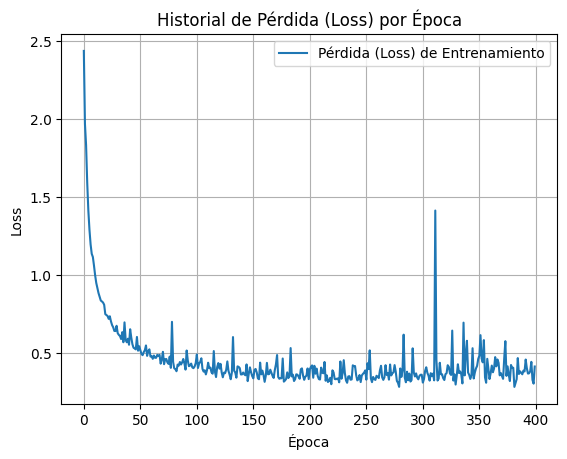


--- FASE 5: Probando modelo en cuda ---
Evaluando modelo contra el conjunto de prueba...


Evaluando: 100%|██████████| 230/230 [00:26<00:00,  8.83batch/s]



          RESULTADOS DE LA EVALUACIÓN (BIOMAS)
Accuracy (Exactitud): 0.7782 (77.82%)
Precision (Precisión - Macro): 0.7499 (74.99%)
Recall (Sensibilidad - Macro): 0.7442 (74.42%)

--- Reporte de Clasificación (Precisión, Recall, F1) ---
                        precision    recall  f1-score   support

              Badlands       0.88      0.98      0.93        64
          Bosque Mixto       0.39      0.16      0.22       459
       Bosque de Abeto       0.85      0.85      0.85       355
       Bosque de Roble       0.60      0.87      0.71       930
Bosque de Roble Oscuro       0.72      0.78      0.75       302
              Desierto       0.94      0.87      0.91       682
                Jungla       0.98      0.90      0.94       139
        Montaña Nevada       0.37      0.32      0.35       173
              Montañas       0.84      0.70      0.76       869
               Pantano       0.89      0.90      0.89       215
             Planicies       0.93      0.90      0.92    

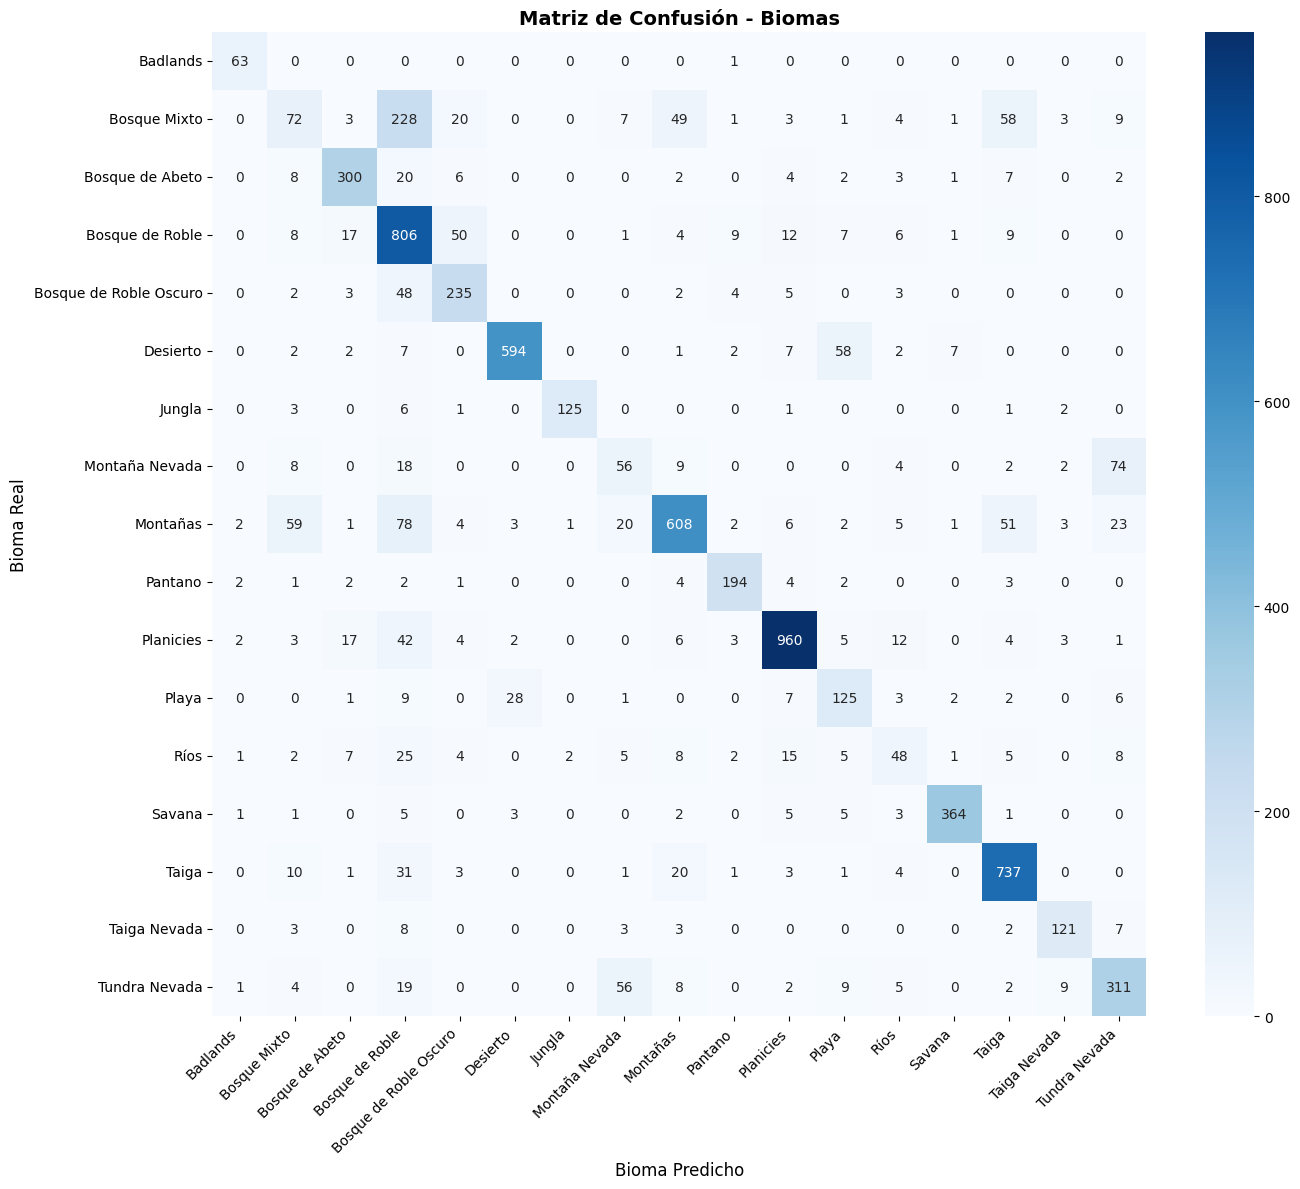

Gráfico de Matriz de Confusión generado.

--- FASE 6: Guardando modelo ---
Modelo guardado en /kaggle/working/auto_model_estandar_20251109_040855.pth

--- FLUJO AUTOMÁTICO COMPLETADO ---


In [9]:
if __name__ == "__main__":
    np.random.seed(SEMILLA_ALEATORIA)
    torch.manual_seed(SEMILLA_ALEATORIA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEMILLA_ALEATORIA)

    tipo_ejecucion_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')

    if tipo_ejecucion_kaggle == 'Interactive':
        print("--- MODO INTERACTIVO (DRAFT) ---")
        print("Iniciando menú principal. Podrá usar 'input()'.\n")
        menu_principal()
    
    else:
        if tipo_ejecucion_kaggle == 'Batch':
            print("--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---")
        else:
            print(f"--- MODO NO INTERACTIVO (Fallback, KAGGLE_KERNEL_RUN_TYPE={tipo_ejecucion_kaggle}) ---")
        
        print("Iniciando flujo automático (sin inputs).\n")
        
        modelo_automatico = None
        params_arquitectura_auto = None
        historial_perdida_auto = []
        dispositivo_auto = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f" (Usando dispositivo: {dispositivo_auto})")

        try:
            print("\n--- FASE 1: Agrupando y verificando el dataset ---")
            if not preparar_y_agrupar_biomas():
                print("Error crítico en la agrupación del dataset. Abortando.")
                sys.exit(1)

            print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
            datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
            if datos_entrenamiento is None:
                print("No se pudieron cargar los datos. Abortando.")
                sys.exit(1)

            print("\n--- FASE 3: Creación de Modelo (CNN) ---")
            tipo_arquitectura_auto = "estandar"
            print(f"Arquitectura seleccionada: {tipo_arquitectura_auto}")
            
            params_arquitectura_auto = {
                'num_classes': numero_de_clases,
                'architecture_type': tipo_arquitectura_auto
            }
            params_creacion_auto = {
                'numero_de_clases': params_arquitectura_auto['num_classes'],
                'tipo_arquitectura': params_arquitectura_auto['architecture_type']
            }
            
            modelo_automatico = ClasificadorBiomasCNN(**params_creacion_auto).to(dispositivo_auto)
            print("\n--- Nueva Red CNN Creada ---")

            epocas_auto = 400
            lr_auto = 0.001
            porcentaje_auto = 1.0
            print(f"\n--- FASE 4: Iniciando Entrenamiento ---")
            print(f"Épocas: {epocas_auto}, LR: {lr_auto}, Dataset: {porcentaje_auto*100:.0f}%")
            
            total_muestras = len(pesos_muestras_tensor)
            muestras_a_usar = int(total_muestras * porcentaje_auto)
            muestreador_auto = torch.utils.data.WeightedRandomSampler(
                weights=pesos_muestras_tensor,
                num_samples=muestras_a_usar,
                replacement=True
            )
            cargador_entrenamiento_auto = DataLoader(datos_entrenamiento,
                                                    batch_size=TAMANO_LOTE,
                                                    sampler=muestreador_auto,
                                                    num_workers=2,
                                                    pin_memory=True)
            
            nueva_perdida_auto = entrenar_modelo(modelo_automatico, cargador_entrenamiento_auto, epocas_auto, lr_auto, dispositivo_auto)
            historial_perdida_auto.extend(nueva_perdida_auto)
            
            print("Generando gráfico de pérdida...")
            graficar_historial_perdida(historial_perdida_auto)

            print(f"\n--- FASE 5: Probando modelo en {dispositivo_auto} ---")
            evaluar_modelo(modelo_automatico, cargador_validacion, dispositivo_auto, nombres_clases)

            print("\n--- FASE 6: Guardando modelo ---")
            marca_temporal = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo_modelo = f"auto_model_estandar_{marca_temporal}.pth"
            guardar_red_neuronal(modelo_automatico, params_arquitectura_auto, nombre_archivo_modelo)
            
            print("\n--- FLUJO AUTOMÁTICO COMPLETADO ---")

        except Exception as e:
            print(f"Ocurrió un error en el flujo automático: {e}")
            import traceback
            traceback.print_exc()
            sys.exit(1)